# 4_data_collector_AskDocs.ipynb

Collects posts from r/AskDocs and analyzes the data.

https://www.reddit.com/r/AskDocs/, 247k, Jul 2013

In [2]:
import pandas as pd
import os
import requests
import json
import csv
import time
import datetime
from pprint import pprint
import pandas as pd
from wordcloud import WordCloud
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

[nltk_data] Downloading package wordnet to /Users/yueyng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
TIME_20200901 = '1598918400'
TIME_20200301 = '1583020800'

def get_pushshift_data(search_query, before, after, sub_reddit_name):
    url = 'https://api.pushshift.io/reddit/search/submission/?q=' + \
        str(search_query) + '&size=1000&after=' + str(after) + '&before=' + \
        str(before) + '&subreddit=' + str(sub_reddit_name)
    
    result = requests.get(url)
    
    try:
        data = json.loads(result.text)
    except:
        print('Exceeding the 200 requests per minute limit.')
        print('Waiting for 60 seconds...')
        time.sleep(60)
        result = requests.get(url)
        data = json.loads(result.text)
        
    return data['data']

def collect_submission_data(submission):
    try:
        body = submission['selftext']
    except KeyError:
        body = '[removed]'

    if body == '' or body == '[removed]' or body == '[deleted]':
        return
    
    submission_data = list()
    title = submission['title']
    submission_id = submission['id']
    score = submission['score']
    num_comments = submission['num_comments']
    full_link = '=HYPERLINK("' + submission['full_link'] + '")'
    created = datetime.datetime.fromtimestamp(submission['created_utc']) #1520561700.0
    try:
        link_flair_text = submission['link_flair_text']
    except KeyError:
        link_flair_text = ''
        
    # We only select "Physician Responded"
    if link_flair_text == 'Physician Responded':
        submission_data.append((submission_id, title, body, score, num_comments, full_link, created, link_flair_text))
        sub_stats[submission_id] = submission_data

def update_submissions_file(stats, filename):
    upload_count = 0
    with open(filename, 'w', newline='', encoding='utf-8') as file: 
        file_writer = csv.writer(file, delimiter=',')
        headers = ['ID', 'Title', 'Body', 'Score', 'Comments', 'Link', 'Date', 'flair']
        file_writer.writerow(headers)
        for sub in stats:
            file_writer.writerow(stats[sub][0])
            upload_count += 1
            
        print(str(upload_count) + " submissions have been uploaded to file: " + filename)

# Collect Data

In [ ]:
sub_reddit = 'AskDocs'
query = ''
before = TIME_20200901
after = TIME_20200301

application_folder = 'data_application'
os.makedirs(application_folder, exist_ok=True)
csv_filename = application_folder + '/' + sub_reddit + '.csv'
excel_filename = application_folder + '/' + sub_reddit + '.xlsx'

sub_stats = {}

data = get_pushshift_data(query, before, after, sub_reddit)

while len(data) > 0:
    for submission in data:
        collect_submission_data(submission)
        
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    
    data = get_pushshift_data(query, before, after, sub_reddit)

update_submissions_file(sub_stats, csv_filename)

# Generate Word Cloud

WordCloud image data_application/AskDocs.png is created.


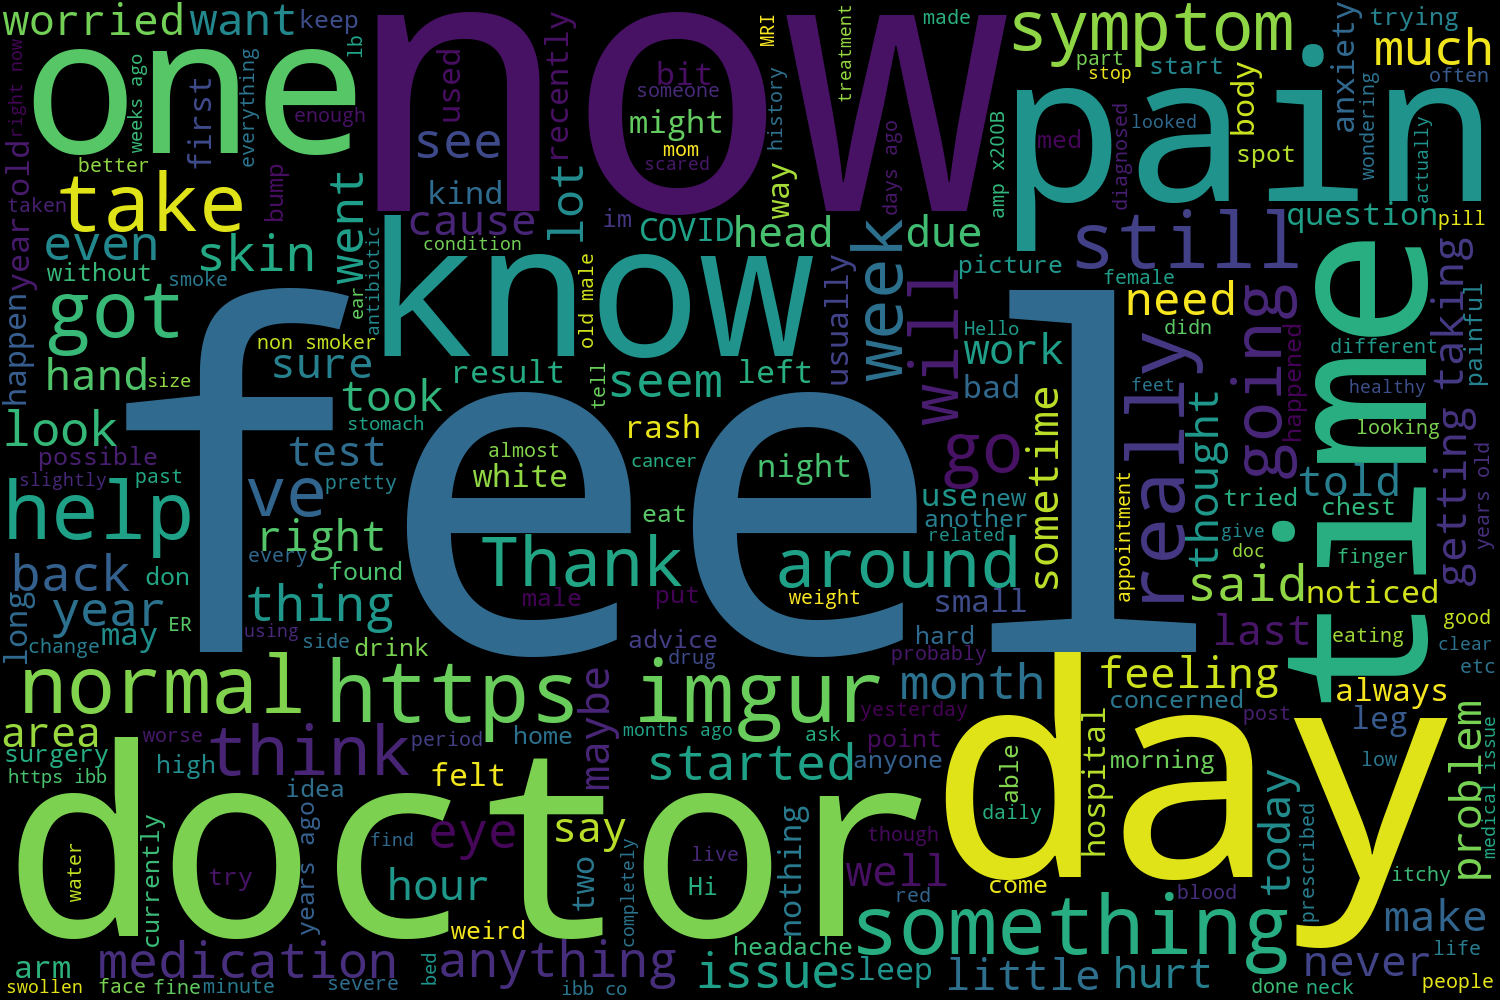

In [12]:
wordcloud_filename = application_folder + '/' + sub_reddit + '.png'

data = pd.read_csv(csv_filename)

content = ''
for index, row in data.iterrows():        
    content += ' ' + str(row['Title']) + ' ' + str(row['Body'])

wordcloud = WordCloud(
                      # background_color = 'white',
                      width = 1500, height = 1000,
                      min_font_size = 15,
                      max_words = 1000,
                      contour_width = 3, contour_color = 'steelblue').generate(content)

wordcloud.to_file(wordcloud_filename)
print('WordCloud image ' + wordcloud_filename + ' is created.')
wordcloud.to_image()

# Perform Topic Modeling

In [13]:
bag_filename = application_folder + '/' + sub_reddit + '_bag.txt'
tfidf_filename = application_folder + '/' + sub_reddit + '_tfidf.txt'

data = pd.read_csv(csv_filename, error_bad_lines=False)

data_text = data[['Body']]

# print(WordNetLemmatizer().lemmatize('went', pos='v'))

stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    if not isinstance(text, str):
        return []
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

sample = 'The ohter day I went to sleep. I have a dream...'

words = []
for word in sample.split(' '):
    words.append(word)
    
# print(words)
# print(preprocess(sample))

processed_docs = data_text['Body'].map(preprocess)

processed_docs[:10]

dictionary = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

bow_doc_100 = bow_corpus[100]

for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                                     dictionary[bow_doc_100[i][0]], 
                                                     bow_doc_100[i][1]))
    
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

corpus_tfidf = tfidf[bow_corpus]

# for doc in corpus_tfidf:
#    pprint(doc)
#    break
    
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)


topics = ''
for idx, topic in lda_model.print_topics(-1):
    entry = 'Topic: ' + str(idx) + '\n' + 'Words: ' + topic + '\n\n'
    # print(entry)
    topics += entry
    
outfile = open(bag_filename, 'w') 
print(topics, file = outfile)
outfile.close()

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

topics = ''
for idx, topic in lda_model_tfidf.print_topics(-1):
    entry = 'Topic: ' + str(idx) + '\n' + 'Words: ' + topic + '\n\n'
    # print(entry)
    topics += entry
    
    
outfile = open(tfidf_filename, 'w') 
print(topics, file = outfile)
outfile.close()

for index, score in sorted(lda_model[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
for index, score in sorted(lda_model_tfidf[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))
    
    
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
        

Word 4 ("better") appears 1 time.
Word 11 ("day") appears 1 time.
Word 17 ("felt") appears 2 time.
Word 24 ("have") appears 2 time.
Word 33 ("issu") appears 4 time.
Word 42 ("make") appears 1 time.
Word 71 ("symptom") appears 2 time.
Word 73 ("tell") appears 1 time.
Word 75 ("throat") appears 1 time.
Word 80 ("wake") appears 1 time.
Word 81 ("week") appears 1 time.
Word 123 ("cough") appears 3 time.
Word 126 ("fever") appears 2 time.
Word 127 ("haven") appears 1 time.
Word 128 ("health") appears 1 time.
Word 138 ("smoker") appears 1 time.
Word 144 ("approxim") appears 1 time.
Word 146 ("possibl") appears 3 time.
Word 178 ("consid") appears 1 time.
Word 179 ("coronavirus") appears 2 time.
Word 183 ("live") appears 1 time.
Word 193 ("virus") appears 1 time.
Word 198 ("caus") appears 2 time.
Word 214 ("worri") appears 1 time.
Word 221 ("itchi") appears 1 time.
Word 257 ("bare") appears 1 time.
Word 269 ("extrem") appears 2 time.
Word 270 ("get") appears 1 time.
Word 314 ("entir") appears 